Source: 

https://medium.com/@brn.pistone/bert-fine-tuning-for-tensorflow-2-0-with-keras-api-9913fc1348f6

https://gist.github.com/bp91

# Imports

In [1]:
import sys  
from shutil           import copyfile
sys.path.insert(0, '../')
# sys.path.insert(0, '../config/')

from CustomTokenizer  import *
from data_preparation import *
from Embedder         import *
from models           import *
from training         import *
from set_project_seed import *

Using TensorFlow backend.


In [10]:
import bert
import os


# model_dir = ".models/uncased_L-12_H-768_A-12"
model_name = "uncased_L-2_H-128_A-2"
model_name = "uncased_L-4_H-128_A-2"
model_name = "uncased_L-12_H-128_A-2"
model_dir  = f"../../embeddings/{model_name}"
model_dir  = f"../../embeddings/all_bert_models/{model_name}"
model_ckpt = os.path.join(model_dir, "bert_model.ckpt")

opt_data_path = "../../data/optimism-twitter-data/tweets_annotation.csv"


bert_params = bert.params_from_pretrained_ckpt(model_dir)
l_bert      = bert.BertModelLayer.from_params(bert_params, name="bert")

# Prepare data

In [11]:
import bert

def createTokenizer(vocab_file):
    '''
        Return BERT tokenizer, based on provided vocabulary file.
    '''

    tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case=True)
    return tokenizer


vocab_file       = os.path.join(model_dir, "vocab.txt")
custom_tokenizer = createTokenizer(vocab_file=vocab_file)

Processing text dataset:
Found 7,475 texts.



("did i just hear clive anderson say peter cooke is on the 'unreliable evidence' panel? excellent @bbcradio4",
 1.0,
 ['did',
  'i',
  'just',
  'hear',
  'clive',
  'anderson',
  'say',
  'peter',
  'cooke',
  'is',
  'on',
  'the',
  "'",
  'unreliable',
  'evidence',
  "'",
  'panel',
  '?',
  'excellent',
  '@',
  'bbc',
  '##rad',
  '##io',
  '##4'])

In [13]:
def vectorize_BERT_data(texts, gold_labels\
                   , custom_tokenizer\
                  , MAX_SEQUENCE_LENGTH=None):
    
    '''
    Given a list of texts (& one of gold labels),
    BERT tokenize them using provided tokenizer 
    
    output: opt_vectorized_tweets, gold_labels
    '''
    #To Do, cut sequencees in map:
    
#     opt_train_tokens = list(map(custom_tokenizer.tokenize, texts))
    opt_train_tokens = [custom_tokenizer.tokenize(t) for t in texts]
    
    if not(MAX_SEQUENCE_LENGTH):
        MAX_SEQUENCE_LENGTH = max(map(lambda x: len(x), list(opt_train_tokens))) + 2
        print("The longest tweet/text has %d BERT tokens." \
          %(MAX_SEQUENCE_LENGTH))
    #else cut the longer sequences:
    
    #Add BERT separators:
#     opt_train_tokens      = list(map(lambda tok: ["[CLS]"] + tok + ["[SEP]"]\
#                            , opt_train_tokens))
    opt_train_tokens      = [["[CLS]"] + toks + ["[SEP]"] for toks in opt_train_tokens]
    
    #Vectorzie tokens + padding:
    opt_vectorized_tweets = [custom_tokenizer.convert_tokens_to_ids(toks) \
                             for toks in opt_train_tokens]
    opt_vectorized_tweets = [t + [0] * (MAX_SEQUENCE_LENGTH - len(t))\
                             for t in opt_vectorized_tweets]
    
    
#     opt_vectorized_tweets = list(map(custom_tokenizer.convert_tokens_to_ids\
#                                , opt_train_tokens))
#     opt_vectorized_tweets = list(map(lambda t: t + [0] * \
#                                 (MAX_SEQUENCE_LENGTH - len(t))\
#                                 , opt_vectorized_tweets))

    #Transform vectors in numpy arrays:
    opt_vectorized_tweets = np.vstack([np.array(ot) for\
                                     ot in opt_vectorized_tweets])
    gold_labels = np.array(gold_labels)

    return opt_vectorized_tweets, gold_labels


opt_tweets, opt_gold_labels = read_OPT_data(data_path=opt_data_path)

print(opt_tweets[0], opt_gold_labels[0], custom_tokenizer.tokenize(opt_tweets[0])[:5])

opt_vectorized_tweets, opt_gold_labels = vectorize_BERT_data(\
                                        opt_tweets, opt_gold_labels\
                                        , custom_tokenizer)

Processing text dataset:
Found 7,475 texts.

The longest tweet/text has 59 BERT tokens.


In [14]:
opt_tweets[1804], len(opt_tweets[1804].split(" "))

('kahit gaano pa kalupet mag rap si smugglaz at abra. . . . . . . . . . . . . . wala paring tatalo pag nag rap na si mudra.  :)',
 34)

# Create model

In [15]:
import bert
import os

def createBertLayer(model_dir):
#     global bert_layer

    bertDir     = model_dir

    bert_params = bert.params_from_pretrained_ckpt(bertDir)
    bert_layer  = bert.BertModelLayer.from_params(bert_params, name="bert")

    bert_layer.apply_adapter_freeze()
    
    return bert_layer

def loadBertCheckpoint(model_dir):
    modelsFolder = model_dir
    #os.path.join(modelBertDir, "multi_cased_L-12_H-768_A-12")
    checkpointName = os.path.join(modelsFolder, "bert_model.ckpt")

    bert.load_stock_weights(bert_layer, checkpointName)
    
bert_layer = createBertLayer(model_dir)

In [21]:
import tensorflow as tf

def createModel(bert_layer, max_seq_length):
#     global model

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(max_seq_length, ), dtype='int32', name='input_ids'),
        bert_layer,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    model.build(input_shape=(None, max_seq_length))

    model.compile(loss='binary_crossentropy', optimizer="adamax", metrics=['accuracy'])

#     model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(lr=0.00001), metrics=['accuracy'])

    print(model.summary())
    
    return model


opt_vectorized_tweets.shape[-1]
bert_model = createModel(bert_layer, 59)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BertModelLayer)        (None, 59, 128)           6351872   
_________________________________________________________________
flatten_2 (Flatten)          (None, 7552)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1933568   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

In [22]:
list(map(len, opt_vectorized_tweets))[:10]

[59, 59, 59, 59, 59, 59, 59, 59, 59, 59]

# Training

In [24]:
bin_opt_gold_labels = binarize_labels(gold_labels=opt_gold_labels)

x_train, y_train, x_dev, y_dev, x_test, y_test = \
    train_dev_test_split(opt_vectorized_tweets\
                         , bin_opt_gold_labels, R_SEED=16)

Splitted data into Train: 5981; Dev: 747; Test: 747.



In [25]:
bert_model.layers

In [26]:
bert_model.layers[0].trainable = False
bert_model.layers[0].trainable

False

In [ ]:
history = bert_model.fit(
        x_train,
        y_train,
        epochs=50,
#         epochs=300,
        batch_size=256,
        validation_data=(x_dev, y_dev),
        verbose=1,
#         callbacks=[cp_callback]
    )

Train on 5981 samples, validate on 747 samples
Epoch 1/50
5981/5981 [==============================] - 159s 27ms/sample - loss: 1.5884 - accuracy: 0.5223 - val_loss: 0.6926 - val_accuracy: 0.5408
Epoch 2/50
5981/5981 [==============================] - 142s 24ms/sample - loss: 0.8395 - accuracy: 0.5173 - val_loss: 0.6930 - val_accuracy: 0.5395
Epoch 3/50
5981/5981 [==============================] - 147s 25ms/sample - loss: 0.7508 - accuracy: 0.5344 - val_loss: 0.6923 - val_accuracy: 0.5422
Epoch 4/50
5981/5981 [==============================] - 146s 24ms/sample - loss: 0.7270 - accuracy: 0.5325 - val_loss: 0.6925 - val_accuracy: 0.5475
Epoch 5/50
5981/5981 [==============================] - 147s 25ms/sample - loss: 0.7084 - accuracy: 0.5449 - val_loss: 0.6898 - val_accuracy: 0.5395
Epoch 6/50
5981/5981 [==============================] - 147s 25ms/sample - loss: 0.7082 - accuracy: 0.5392 - val_loss: 0.6919 - val_accuracy: 0.5328
Epoch 7/50
5981/5981 [==============================] - 146

# Plots

In [14]:
import matplotlib.pyplot as plt

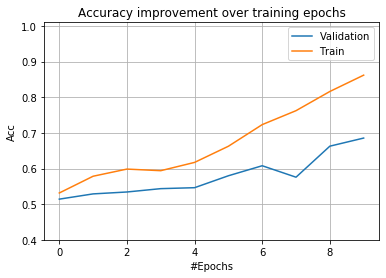

In [17]:

plt.title("Accuracy improvement over training epochs")
# plt.plot(hist_df["accuracy"])
# plt.plot(training_errors, label="Training Acc")
# plt.plot(validation_errors, label = "Validation Acc" )
plt.plot(history.history["val_accuracy"], label="Val Acc.")
plt.plot(history.history["accuracy"], label="Train Acc.")
plt.ylabel("Acc")
plt.xlabel("#Epochs")
plt.grid()
plt.ylim(0.4, ymax = 1.01)
plt.legend()
plt.show()

In [18]:
history_1 = bert_model.fit(
        x_train,
        y_train,
        epochs=10,
#         epochs=300,
        batch_size=256,
        validation_data=(x_dev, y_dev),
        verbose=1,
#         callbacks=[cp_callback]
    )

Train on 5981 samples, validate on 747 samples
Epoch 1/10
5981/5981 [==============================] - 47s 8ms/sample - loss: 0.3212 - accuracy: 0.8935 - val_loss: 0.5890 - val_accuracy: 0.6760
Epoch 2/10
5981/5981 [==============================] - 47s 8ms/sample - loss: 0.2629 - accuracy: 0.9216 - val_loss: 0.6239 - val_accuracy: 0.6760
Epoch 3/10
5981/5981 [==============================] - 46s 8ms/sample - loss: 0.2144 - accuracy: 0.9388 - val_loss: 0.6172 - val_accuracy: 0.6881
Epoch 4/10
5981/5981 [==============================] - 47s 8ms/sample - loss: 0.1688 - accuracy: 0.9564 - val_loss: 0.6620 - val_accuracy: 0.6801
Epoch 5/10
5981/5981 [==============================] - 46s 8ms/sample - loss: 0.1383 - accuracy: 0.9637 - val_loss: 0.6374 - val_accuracy: 0.7095
Epoch 6/10
5981/5981 [==============================] - 45s 8ms/sample - loss: 0.1095 - accuracy: 0.9732 - val_loss: 0.6619 - val_accuracy: 0.7229
Epoch 7/10
5981/5981 [==============================] - 45s 8ms/sample 

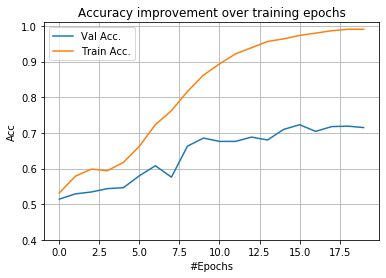

In [20]:

plt.title("Accuracy improvement over training epochs")
# plt.plot(hist_df["accuracy"])
# plt.plot(training_errors, label="Training Acc")
# plt.plot(validation_errors, label = "Validation Acc" )
plt.plot(history.history["val_accuracy"] + history_1.history["val_accuracy"], label="Val Acc.")
plt.plot(history.history["accuracy"] + history_1.history["accuracy"], label="Train Acc.")
plt.ylabel("Acc")
plt.xlabel("#Epochs")
plt.grid()
plt.ylim(0.4, ymax = 1.01)
plt.legend()
plt.show()

In [ ]:
def fitModel(training_set, training_label\
             , testing_set, testing_label):
    checkpointName = os.path.join(modelDir, "bert_faq.ckpt")

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointName,
                                                     save_weights_only=True,
                                                     verbose=1)

    # callback = StopTrainingClassComplete()

    history = model.fit(
        training_set,
        training_label,
        epochs=300,
        validation_data=(testing_set, testing_label),
        verbose=1,
        callbacks=[cp_callback]
    )

# Drafts

In [ ]:
import csv
import os
import random

def loadData(tokenizer):
    fileName = os.path.join(dataDir, "data.csv")
    fileTestName = os.path.join(dataDir, "data_test.csv")

    data = []
    data_test = []
    train_set = []
    train_labels = []
    test_set = []
    test_labels = []

    with open(fileName, encoding='utf-8') as csvFile:
        csv_reader = csv.reader(csvFile, delimiter=";")
        line_count = 0
        for row in csv_reader:
            if line_count > 0:
                data.append(row) 
            line_count +=1
    csvFile.close()

    with open(fileTestName, encoding='utf-8') as csvFileTest:
        csv_reader_test = csv.reader(csvFileTest, delimiter=";")
        line_count = 0
        for row in csv_reader_test:
            if line_count > 0:
                data_test.append(row)
            line_count +=1
    csvFileTest.close()

    shuffled_set = random.sample(data, len(data))
    training_set = shuffled_set[0:]
    shuffled_set_test = random.sample(data_test, len(data_test))
    testing_set = shuffled_set_test[0:]

    for el in training_set:
        train_set.append(el[1])
        zeros = [0] * classes
        zeros[int(el[0]) - 1] = 1
        train_labels.append(zeros)

    for el in testing_set:
        test_set.append(el[1])
        zeros = [0] * classes
        zeros[int(el[0]) - 1] = 1
        test_labels.append(zeros)

    defineTokenizerConfig(train_set)

    train_tokens = map(tokenizer.tokenize, train_set)
    train_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], train_tokens)
    train_token_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))

    train_token_ids = map(lambda tids: tids + [0] * (max_seq_length - len(tids)), train_token_ids)
    train_token_ids = np.array(list(train_token_ids))

    test_tokens = map(tokenizer.tokenize, test_set)
    test_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], test_tokens)
    test_token_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

    test_token_ids = map(lambda tids: tids + [0] * (max_seq_length - len(tids)), test_token_ids)
    test_token_ids = np.array(list(test_token_ids))

    train_labels_final = np.array(train_labels)
    test_labels_final = np.array(test_labels)

    return train_token_ids, train_labels_final, test_token_ids, test_labels_final

train_set, train_labels, test_set, test_labels = loadData(tokenizer)


In [24]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten

max_seq_len = 128
max_seq_len = 128

l_input_ids      = keras.layers.Input(shape=(max_seq_len,), dtype='int32')
l_token_type_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32')

# using the default token_type/segment id 0
output = Dense(2)(Flatten()(l_bert(l_input_ids)))                              # output: [batch_size, max_seq_len, hidden_size]
model = keras.Model(inputs=l_input_ids, outputs=output)
model.build(input_shape=(None, max_seq_len))

# provide a custom token_type/segment id as a layer input
# output = l_bert([l_input_ids, l_token_type_ids])          # [batch_size, max_seq_len, hidden_size]
# model = keras.Model(inputs=[l_input_ids, l_token_type_ids], outputs=output)
# model.build(input_shape=[(None, max_seq_len), (None, max_seq_len)])

In [25]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 128)          4369152   
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 32770     
Total params: 4,401,922
Trainable params: 4,401,922
Non-trainable params: 0
_________________________________________________________________


In [21]:
do_lower_case = not (model_name.find("cased") == 0 \
                     or model_name.find("multi_cased") == 0)
bert.bert_tokenization.validate_case_matches_checkpoint(do_lower_case\
                                                        , model_ckpt)
vocab_file = os.path.join(model_dir, "vocab.txt")
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file\
                                                 , do_lower_case)
tokens = tokenizer.tokenize("Hello, BERT-World!")
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [9]:
tokens, token_ids

(['hello', ',', 'bert', '-', 'world', '!'],
 [7592, 1010, 14324, 1011, 2088, 999])

In [14]:
import numpy as np

np.array(token_ids + [0] * (128 - len(token_ids))).shape

(128,)

In [27]:
model.predict((np.array(token_ids + \
                        [0] * (128 - len(token_ids))))\
              .reshape(1, -1))#.shape

array([[ 3.5423844 , -0.43246394]], dtype=float32)

In [10]:
model.predict(token_ids)

ValueError: Error when checking input: expected input_3 to have shape (128,) but got array with shape (1,)

In [9]:
l_bert.apply_adapter_freeze()

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 128)          4369152   
Total params: 4,369,152
Trainable params: 4,369,152
Non-trainable params: 0
_________________________________________________________________


In [11]:
from bert import tokenization

In [18]:
tokenization.bert_tokenization.whitespace_tokenize("ana are multe n\
                                                   sda")

['ana', 'are', 'multe', 'n', 'sda']

In [19]:
bert.

<module 'bert' from '/home/stefan/anaconda3/envs/nlp-tf2/lib/python3.6/site-packages/bert/__init__.py'>

In [23]:
hash((1,2))

3713081631934410656

In [2]:
!cat ../set_project_seed.py

#reproducible keras results:
# https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_sessi

In [3]:
import bert